In [1]:
import os
import skimage
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [2]:
from skimage import color,transform,data

In [3]:
path='C:/Users/jinwei/fruits-360_dataset/fruits-360/Training'
#测试文件目录#
path1='C:/Users/jinwei/fruits-360_dataset/fruits-360/Test'

In [4]:
import pandas as pd

In [5]:
def pro10_rand(num):
    l=[]
    n=num
    while n!=len(l):
        x=random.randint(0,77)
        if x in l:
            cotinue
        else:
            l.append(x)
    return l


In [44]:
sub_dir[0]

'Apple Braeburn'

In [6]:
import random
data_dir=path
data_dir1=path1
sub_dir=[d for d in os.listdir(data_dir) if os.path.isdir(data_dir+'/'+d)]#训练文件夹子路径
sub_dir1=[d for d in os.listdir(data_dir1) if os.path.isdir(data_dir1+'/'+d)]#测试文件夹子路径
def load_data(data_dir,data_dir1):
    labels=[]
    images=[]
    labels1=[]
    images1=[]
    l=pro10_rand(10)
    k=0
    for i in l:
        image_path = os.path.join(data_dir,sub_dir[i])
        test_path = os.path.join(data_dir1,sub_dir1[i])
        for p in os.listdir(image_path):#提取训练的10个类
            if p.endswith('.jpg'):
                images.append(skimage.data.imread(image_path+'/'+p))
                labels.append(k)
        for p in os.listdir(test_path):#提取训练的10个类
            if p.endswith('.jpg'):
                images1.append(skimage.data.imread(test_path+'/'+p))
                labels1.append(k)
        k+=1

    return images,labels,images1,labels1

In [85]:
def img_show(data_dir):
    plt.figure(figsize=(15,15))
    i=1
    for f in sub_dir:#遍历各图片文件目录
        p=os.listdir(data_dir+'/'+f)
        p=sorted(p,key=len)#对文件列表按文件名大小排序
        img=skimage.data.imread(data_dir+'/'+f+'/'+p[4])
        plt.subplot(11,7,i)
        plt.axis('off')
        plt.title("Label:{0}".format(f))
        plt.imshow(img)
        i+=1
    plt.show

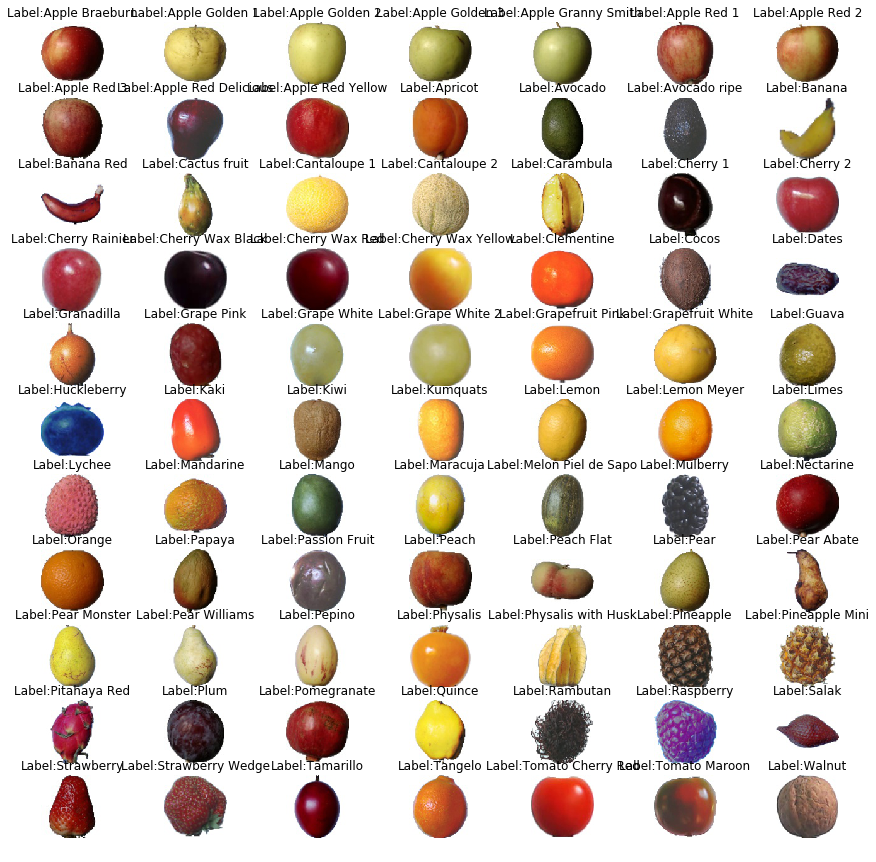

In [47]:
img_show(path)

In [7]:
#加载并裁剪图片
images,labels,img_t,lab_t=load_data(path,path1)
img_train=[(skimage.transform.resize(item,(28,28))) for item in images]

img_test=[(skimage.transform.resize(item,(28,28))) for item in img_t]

C:\ProgramData\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [8]:
## 打乱
def shuffle_datas(datas, labels):
    for i in range(len(datas) - 1):
        index = np.random.randint(i + 1, len(datas))
        data_t = datas[i]
        label_t = labels[i]
        datas[i] = datas[index]
        labels[i] = labels[index]
        datas[index] = data_t
        labels[index] = label_t

In [9]:
shuffle_datas(img_train,labels)
shuffle_datas(img_test,lab_t)

In [10]:
#训练集
train_a=np.array(img_train)
train_la=np.array(labels)
#测试集
img_ta=np.array(img_test)
lab_ta=np.array(lab_t)

In [11]:
#图像灰度化和改变维度
#训练集
train_xg=color.rgb2gray(train_a)
train_xr=np.reshape(train_xg,(train_xg.shape[0],28,28,1))
#测试集
test_xg=color.rgb2gray(img_ta)
test_xr=np.reshape(test_xg,(test_xg.shape[0],28,28,1))



In [13]:
#标签转one-hot码
test_labels=pd.get_dummies(lab_ta,sparse=True)
train_labels=pd.get_dummies(train_la,sparse=True)

In [14]:
def gener_datas_batch(inputs,batch_size):
    ## 计算块数
    batch_count = int(len(inputs) / batch_size)
    for index in range(batch_count):
        ## 获取下标为 x * size 到 (x + 1) * size 的数据块
        ## 例如： 4 * 256 : (4 + 1) * 256 = 1024 : 1280
        datas_batch = inputs[index * batch_size : (index + 1) * batch_size]
        yield datas_batch

In [18]:
import time
n_classes=10
x=tf.placeholder(tf.float32)
y=tf.placeholder(tf.float32)
keep_prob = tf.placeholder(tf.float32)

epochs=20
learning_rate=0.001
#learning_rate=0.1
batch_size=80
dropout=0.5
filter_width=5
filter_height=5
depth_in=1
depth_out1=32
depth_out2=64
f_height=28

#权值和偏置参数
Weights={"wc1":tf.Variable(tf.random_normal([filter_height,filter_width,depth_in,depth_out1])),\
        "wc2":tf.Variable(tf.random_normal([filter_height,filter_width,depth_out1,depth_out2])),\
        "wd1":tf.Variable(tf.random_normal([int((f_height*f_height/16)*depth_out2),512])),\
        "wd2":tf.Variable(tf.random_normal([512,256])),\
        "out":tf.Variable(tf.random_normal([256,n_classes]))}

bias={"bc1":tf.Variable(tf.random_normal([depth_out1])),\
      "bc2":tf.Variable(tf.random_normal([depth_out2])),\
      "bd1":tf.Variable(tf.random_normal([512])),\
      "bd2":tf.Variable(tf.random_normal([256])),\
      "out":tf.Variable(tf.random_normal([n_classes]))}

#卷积层和池化层

def conv2d(x,W,b,stride=1):
    x=tf.nn.conv2d(x,W,strides=[1,stride,stride,1],padding="SAME")
    x=tf.nn.bias_add(x,b)
    return tf.nn.relu(x)
def maxpool2d(x,stride=2):
    return tf.nn.max_pool(x,ksize=[1,stride,stride,1],strides=[1,stride,stride,1],padding="SAME")


#建模
def conv_net(x_,W,b,dropout):
    x=tf.reshape(x_,[-1,28,28,1])
    #卷积层1
    conv1=conv2d(x,W["wc1"],b["bc1"])
    conv1=maxpool2d(conv1,2)
    
    #卷积层2
    conv2=conv2d(conv1,W["wc2"],b["bc2"])
    conv2=maxpool2d(conv2,2)
    
    #全连接层
    fc1=tf.reshape(conv2,[-1,W["wd1"].get_shape().as_list()[0]])
    fc1=tf.matmul(fc1,W["wd1"])
    fc1=tf.add(fc1,b["bd1"])
    fc1=tf.nn.relu(fc1)
    
    #dropout
    fc1=tf.nn.dropout(fc1,dropout)
    
    #输出层
    out=tf.matmul(fc1,W["out"])
    out=tf.add(out,b["out"])
    
    return out

# def conv2d(x,W,b,strides=1):
#     x = tf.nn.conv2d(x,W,strides=[1,strides,strides,1],padding='SAME')
#     x = tf.nn.bias_add(x,b)
#     return tf.nn.relu(x)

# def maxpool2d(x,stride=2):
#     return tf.nn.max_pool(x,ksize=[1,stride,stride,1],strides=[1,stride,stride,1],padding='SAME')


# def conv_net(x,weights,biases,dropout):
#     x = tf.reshape(x,shape=[-1,28,28,1])
  
#     ## Convolutional layer 1
#     conv1 = conv2d(x,weights['wc1'],biases['bc1'])
#     conv1 = maxpool2d(conv1,2)
#     ## Convolutional layer 2
#     conv2 = conv2d(conv1,weights['wc2'],biases['bc2'])
#     conv2 = maxpool2d(conv2,2)
#     ## Now comes the fully connected layer
#     fc1 = tf.reshape(conv2,[-1,weights['wd1'].get_shape().as_list()[0]])
#     fc1 = tf.add(tf.matmul(fc1,weights['wd1']),biases['bd1'])
#     fc1 = tf.nn.relu(fc1)
#     ## Apply Dropout
#     fc1 = tf.nn.dropout(fc1,dropout)
    
#     ## Now comes the fully connected layer
#     fc2 = tf.add(tf.matmul(fc1,weights['wd2']),biases['bd2'])
#     fc2 = tf.nn.relu(fc2)
#     ## Apply Dropout
#     fc2 = tf.nn.dropout(fc2,dropout)
    
#     ## Output class prediction
#     out = tf.add(tf.matmul(fc2,weights['out']),biases['out'])
#     return out


pred=conv_net(x,Weights,bias,keep_prob)
# tf.summary.histogram('layer1/Weights',Weights)
# tf.summary.histogram('layer1/bias',bias)

cost=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=pred,labels=y))
#优化器
optimizer=tf.train.AdamOptimizer(learning_rate).minimize(cost)
#optimizer=tf.train.GradientDescentOptimizer(0.01).minimize(cost)
#计算模型
correct_pred=tf.equal(tf.argmax(pred,1),tf.argmax(y,1))
accuracy=tf.reduce_mean(tf.cast(correct_pred,tf.float32))
tf.summary.scalar('loss',accuracy)
#tensorboard全局初始化
merged=tf.summary.merge_all()

batch_num = int(len(train_xg)/batch_size)

init=tf.global_variables_initializer()

start_time = time.time()

with tf.Session() as sess:
    sess.run(init)
    saver = tf.train.Saver()
    for  i  in range(epochs):
        acc_sum=0
        loss_sum=0
        train_x=gener_datas_batch(train_xg,batch_size)
        train_y=gener_datas_batch(train_labels,batch_size)
        for  j  in range(batch_num):
            batch_x = next(train_x)
            batch_y = next(train_y)
            sess.run(optimizer, feed_dict={x:batch_x,y:batch_y,keep_prob:0.75})#传入数据
            loss,acc = sess.run([cost,accuracy],feed_dict={x:batch_x,y:batch_y,keep_prob: 1.})
            #if epochs % 1 == 0:
                #print("Epoch:", '%04d' % (i+1),"cost=", "{:.9f}".format(loss),"Training accuracy","{:.5f}".format(acc))
            acc_sum+=acc
            loss_sum+=loss
        acc_avg=acc_sum/batch_num
        loss_avg=loss_sum/batch_num
        print("Epoch:", '%04d' % (i+1),"cost=", "{:.9f}".format(loss_avg),"Training accuracy","{:.5f}".format(acc_avg))
    print('Optimization Completed')
    
    
    #测试准确率计算
    y1 = sess.run(pred,feed_dict={x:test_xr,keep_prob: 1})
    test_accu=sess.run(accuracy,feed_dict={x:test_xr,y:test_labels,keep_prob: 1})
    print('Testing Accuracy:%.4f' % test_accu)


Epoch: 0001 cost= 68327.850762039 Training accuracy 0.47459
Epoch: 0002 cost= 6974.262008917 Training accuracy 0.84754
Epoch: 0003 cost= 2272.995224499 Training accuracy 0.92541
Epoch: 0004 cost= 1236.365478641 Training accuracy 0.95143
Epoch: 0005 cost= 544.582064644 Training accuracy 0.97111
Epoch: 0006 cost= 204.360776862 Training accuracy 0.98545
Epoch: 0007 cost= 126.987432433 Training accuracy 0.99283
Epoch: 0008 cost= 60.290908978 Training accuracy 0.99590
Epoch: 0009 cost= 53.342562691 Training accuracy 0.99816
Epoch: 0010 cost= 64.649157446 Training accuracy 0.99652
Epoch: 0011 cost= 34.182465788 Training accuracy 0.99898
Epoch: 0012 cost= 24.783505424 Training accuracy 0.99877
Epoch: 0013 cost= 23.172906407 Training accuracy 0.99918
Epoch: 0014 cost= 13.175281462 Training accuracy 0.99939
Epoch: 0015 cost= 10.440381660 Training accuracy 0.99939
Epoch: 0016 cost= 0.000000000 Training accuracy 1.00000
Epoch: 0017 cost= 1.961821259 Training accuracy 0.99980
Epoch: 0018 cost= 5.0